In [159]:
#! pip install numpy pandas ipywidgets tqdm PyQt6 scipy gymnasium "gymnasium[other]" "gymnasium[classic-control]"

#### Imports

In [160]:
from typing import Optional
import numpy as np
import gymnasium as gym
from collections import defaultdict
from tqdm import tqdm
from matplotlib import pyplot as plt
import pickle
from IPython.display import display, clear_output
import copy
from scipy.ndimage import zoom
from tqdm.notebook import tqdm
import pandas as pd
from collections import defaultdict

N_EPISODES = 10000
UPDATE_STEP = 1     # Update q_values after each step
BETA = 0.6
ALPHA = 0.1
GAMMA = 0.9
SIZE = 10
STEPS = SIZE * SIZE
EPSILON = 0.8
EVALUATION_STEPS = 100

# TODO: Increase sensor range
# TODO: Forstå boltzmann Beta
# TODO: Dobbelt tjek Q-values
# TODO: Kører pyton noget multithreading?(Episode/sekund falder ikke ved træning af flere agenter?)
# TODO: kan gå ind i væg uden at blive punsihed.

#spørgsmål
# TODO: Spørgsmål! obs af reward var -1, 1 men rewards var jo mellem 0-10. efter ændring skete der intet? bruger vi overhovedet obs rigtigt?
# TODO: bland visit_near og nearby agent sammen? mindre Q table?
# TODO: er 1 "test" nok, til at vurdere på ens ændring, siden vi gør det over fx 20.000 episoder? så er det jo teknisk set ikke en sample size  på 1, men kan man konkludere og vurdere på 1 test alene?


#### World class

In [161]:
class GridWorldEnv(gym.Env):

    def __init__(self, size: int = 10):
        # The size of the square grid
        self.size = size
        self.trajectory = []
        self.world = np.zeros((size, size))
        self.visited_states = np.zeros((size, size))
        self.global_location = np.zeros((size, size))


        # Define the agent and target location; randomly chosen in `reset` and updated in `step`
        self._agent_location = np.array([1, 1], dtype=np.int32)
        self._visited_states_near = np.zeros((3, 3))
        self._reward_near = np.zeros(4)
        self._nearby_agent = np.zeros((5,5))
        


        # Observations are dictionaries with the agent's and the target's location.
        self.observation_space = gym.spaces.Dict(
            {
            "visited_states_near": gym.spaces.Box(0, 1, shape=(3, 3), dtype=int),
            "reward_near": gym.spaces.Box(0, 10, shape=(0, 4), dtype=int),
            "nearby_agent": gym.spaces.Box(0, 1, shape=(5, 5), dtype=int),
            }
        )

        # We have 8 actions, corresponding to "right", "up", "left", "down" and diagonal
        self.action_space = gym.spaces.Discrete(4)
        # Dictionary maps the abstract actions to the directions on the grid
        self._action_to_direction = {
            0: np.array([1, 0]),  # right
            1: np.array([0, 1]),  # up
            2: np.array([-1, 0]),  # left
            3: np.array([0, -1]),  # down
            # 4: np.array([1, 1]),  # up-right
            # 5: np.array([-1, 1]),  # up-left
            # 6: np.array([-1, -1]),  # down-left
            # 7: np.array([1, -1]),  # down-right
        }
    
    def normalize_env_reward(self):
        # Normalize the world to be between 0 and 1
        min_val = 0
        max_val = 10
        self.world = (self.world - min_val) / (max_val - min_val)

    def scale_env(self):
        # Scale all rewards to be between 0 and 10
        min_val = np.min(self.world)
        max_val = np.max(self.world)
        self.world = (self.world - min_val) / (max_val - min_val) * 10
        self.world = np.round(self.world, 0)


    def random_env(self):
        self.world = np.random.randint(1, 11, size=(self.size, self.size))

    def heatmap_env(self):
        with open("../Kaspers_chad_pdfer_mm/heatmap/data/heatmap.pkl", "rb") as f:
            heatmap = np.rot90(pickle.load(f), k=1)
        
        heatmap_scaled = zoom(heatmap, (self.size / heatmap.shape[0], self.size / heatmap.shape[1]), order=1)  # Bilinear interpolation

        self.world = heatmap_scaled
        # self.normalize_env_reward()
        self.scale_env()
    
    def reset_visited_states(self):
        self.visited_states = np.zeros((self.size, self.size))
    
    def world_from_matrix(self, matrix):
        self.world = matrix

    def setReward(self, x, y , reward):
        self.world[x][y] = reward

    def _get_info(self):
        return {
            "agent_location": self._agent_location
        }

    def _get_obs(self):
        return {
            "visited_states_near": self._visited_states_near,
            "reward_near": self._reward_near,
            "nearby_agent": self._nearby_agent,
        }
    

    def reset_global_location(self):
        self.global_location = np.zeros((self.size, self.size))

    def reset(self, agents, seed: Optional[int] = None, options: Optional[dict] = None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        # Choose the agent's location uniformly at random
        for agent in agents:
            agent.location = self.np_random.integers(0, self.size -1, size=2, dtype=int)
        
        # reset visited states near and reward_near
        self.reset_visited_states()
        self.reset_global_location()


        observation = self._get_obs()
        info = self._get_info()



        return observation, info

    def getReward(self):
        return self.world[self._agent_location[0], self._agent_location[1]]


    def check_rewards_near(self):
        x, y = self._agent_location
        rewards = []
        for dx, dy in self._action_to_direction.values():
            nx, ny = x + dx, y + dy
            if 0 <= nx < self.size and 0 <= ny < self.size:
                rewards.append(self.world[nx][ny])
            else:
                rewards.append(-np.inf)

        # Find the index of the maximum reward
        max_reward_index = np.argmax(rewards)

        # Create a one-hot encoded vector for the action space
        self._reward_near = np.zeros(8)
        self._reward_near[max_reward_index] = 1

    def check_visited_near(self):
        # Create a 3x3 local view centered on the agent
        x, y = self._agent_location

        for dx in range(-1, 2):
            for dy in range(-1, 2):
                nx, ny = x + dx, y + dy
                if 0 <= nx < self.size and 0 <= ny < self.size:
                    self._visited_states_near[dx + 1, dy + 1] = self.visited_states[nx][ny]

    def update_global_location(self):
        self.global_location[self._agent_location[0], self._agent_location[1]] = 1

    def check_nearby_agents(self):
        """Checks for other agents in a 5x5 grid centered on the agent."""
        x, y = self._agent_location

        for dx in range(-2, 3): 
            for dy in range(-2, 3):
                nx, ny = x + dx, y + dy

                # Check if within bounds
                if 0 <= nx < self.size and 0 <= ny < self.size:
                    self._nearby_agent[dx + 2, dy + 2] = self.global_location[nx][ny]  

    def step(self, action):
        # Map the action (element of {0,1,2,3,4,5,6,7}) to the direction we walk in
        direction = self._action_to_direction[action]

        self.check_visited_near()
    
        self.global_location[self._agent_location[0], self._agent_location[1]] = 0
        # We use `np.clip` to make sure we don't leave the grid bounds
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self.size - 1
        )
        self.global_location[self._agent_location[0], self._agent_location[1]] = 1

         # --- Update `visited_states` ---
        grid_x, grid_y = self._agent_location
        self.visited_states[grid_x][grid_y] = 1

        self.check_rewards_near()
        self.check_nearby_agents()

        # An environment is completed if and only if the agent has searched all states
        terminated = False
        truncated = False
        reward = self.getReward()
        observation = self._get_obs()
        info = self._get_info()

        

        return observation, reward, terminated, truncated, info
    
    

#### Agent Class
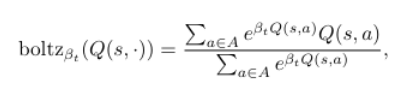

In [162]:
class SAR_agent:
    def __init__(
        self,
        agent_id,
        env: gym.Env,
        alpha: float,
        beta,
        epsilon,
        gamma: float = 0.0
    ):
        self.agent_id = agent_id
        self.env = env
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))
        self.location = np.array([-1, -1], dtype=np.int32)

        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.beta = beta

        self.trajectory = []
        self.training_error = []

    def reset_trajectory(self):
        self.trajectory = []

    def add_trajectory(self, info):
        location = info['agent_location']
        self.trajectory.append(location)

    def get_state(self, obs: dict):
        visited_states_near = obs["visited_states_near"]
        reward_near = obs["reward_near"]
        nearby_agent = obs["nearby_agent"]

        return (
            np.sum(visited_states_near),
            tuple(reward_near.flatten()),
            np.sum(nearby_agent)
        )

    def mega_greedy_swarm_action(self, obs: dict) -> int:
        agent_state = self.get_state(obs)
        display(self.q_values[agent_state])
        print("Taking action: ", int(np.argmax(self.q_values[agent_state])))
        return int(np.argmax(self.q_values[agent_state]))

    def get_action_boltz(self, obs: dict) -> int:
        agent_state = self.get_state(obs)

        q_values = self.q_values[agent_state]
        exp_q = np.exp(self.beta * q_values - np.max(self.beta * q_values))
        boltzmann_probs = exp_q / np.sum(exp_q)

        return np.random.choice(len(q_values), p=boltzmann_probs)

    def get_action_epsilon(self, obs: dict) -> int:
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            agent_state = self.get_state(obs)
            return int(np.argmax(self.q_values[agent_state]))

    def update(
        self,
        obs: dict,  
        action: int,
        reward: float,
        terminated: bool,
        next_obs: dict  
    ):
        agent_state = self.get_state(obs)
        next_agent_state = self.get_state(next_obs)

        future_q_value = (not terminated) * np.max(self.q_values[next_agent_state])

        temporal_difference = (
            reward + self.gamma * future_q_value - self.q_values[agent_state][action]
        )

        self.q_values[agent_state][action] += self.alpha * temporal_difference
        self.training_error.append(temporal_difference)


    def plot_trajectory(self, time_step):
        plt.figure()
        for i, state in enumerate(self.trajectory):
            clear_output(wait=True)
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.title("Agent's Trajectory Simulation")
            plt.grid(True)
            
            past_x, past_y = zip(*self.trajectory[: i + 1])
            plt.plot(past_x, past_y, "bo-", label="Past Path")

            plt.plot(state[0], state[1], "ro", markersize=10, label="Current Position")
            
            plt.legend()
            plt.xlim(-1, self.env.size + 1)
            plt.ylim(-1, self.env.size + 1)
            plt.pause(time_step)
        
        plt.show()

#### Swarm Class

In [163]:
class swarm:
    def __init__(self, env, agents, n_episodes, update_step=1):
        self.env = env
        self.agents = agents
        self.visited_states = [[0 for _ in range(env.size)] for _ in range(env.size)]
        self.cum_reward = []    # :TODO overvej nyt navn
        self.episode_cum_reward = [0 for _ in range(N_EPISODES)]
        self.n_episodes = n_episodes
        self.revisits = []
        self.info_pr_episode = []
        self.update_step = update_step

    #writes to visited states
    def state_visited(self, obs):
        x, y = obs['agent']
        self.visited_states[y][x] = 1  # mark as visited

    #reads from visited states
    def state_has_been_visited(self, obs):
        x, y = obs['agent']
        return self.visited_states[y][x] == 1

    def reset_trajectory(self):
        for agent in self.agents:
            agent.reset_trajectory()

    def calc_revisits(self, train_env):
        revisited = 0
        for i in range(train_env.size):
            for j in range(train_env.size):
                revisited += train_env.visited_states[i][j]
                self.revisits.append(revisited)

    def calc_info(self, train_env):
        visited_rewards = 0
        for i in range(train_env.size):
            for j in range(train_env.size):
                visited_rewards += self.env.world[i][j] * train_env.visited_states[i][j]

    
        total_rewards = np.sum(self.env.world)
        
        self.info_pr_episode.append(visited_rewards / total_rewards)


    def train_swarm(self, max_steps):
        progress_bar = tqdm(range(self.n_episodes), desc="Training Progress", unit="episode", leave=False)

        for episode in progress_bar:
            train_env = copy.deepcopy(self.env)
            progress_bar.set_description(f"Training Progress (Episode {episode + 1}/{self.n_episodes})")

            # Reset the environment for the start of the episode
            obs, info = train_env.reset(self.agents)
            self.reset_trajectory()
            
            self.cum_reward = 0
            terminated = False
            steps = 0
            done = False

            # Run the episode until termination
            while not done:

                for agent in self.agents:
                    x, y = info['agent_location']
                    train_env.setReward(x, y, -10)

                    action = agent.get_action_boltz(obs)
                    # action = agent.get_action_boltz(obs, steps)

                    next_obs, reward, terminated, truncated, info = train_env.step(action)
                    agent.add_trajectory(info)

                    if(steps % self.update_step == 0):
                        agent.update(obs, action, reward, terminated, next_obs)

                    self.episode_cum_reward[episode] += reward

                    if steps >= max_steps:
                        terminated = True

                    done = terminated or truncated
                    obs = next_obs
                    steps += 1
        
        progress_bar.close()


    def evaluate_swarm(self, max_steps, number_of_episode):
        progress_bar = tqdm(range(number_of_episode), desc="Training Progress", unit="episode", leave=False)

        for episode in progress_bar:
            train_env = copy.deepcopy(self.env)
            progress_bar.set_description(f"Training Progress (Episode {episode + 1}/{number_of_episode})")

            # Reset the environment for the start of the episode
            obs, info = train_env.reset(self.agents)
            self.reset_trajectory()
            
            self.cum_reward = 0
            terminated = False
            steps = 0
            done = False

            # Run the episode until termination
            while not done:

                for agent in self.agents:
                    x, y = info['agent_location']
                    train_env.setReward(x, y, -10)

                    action = agent.mega_greedy_swarm_action(obs)
                    
                    # action = agent.get_action_boltz(obs, steps)

                    next_obs, reward, terminated, truncated, info = train_env.step(action)
                    agent.add_trajectory(info)

                    self.episode_cum_reward[episode] += reward

                   

                    if steps >= max_steps:
                        terminated = True

                    done = terminated or truncated
                    obs = next_obs
                    steps += 1
            
            self.episode_cum_reward.append(self.cum_reward)
            self.calc_revisits(train_env)
            self.calc_info(train_env)

        progress_bar.close()



    def plot_reward_episode(self, number_of_episodes, window_size=50):
        """Plots reward per episode with a rolling mean and shaded variance"""
        plt.figure()
        
        x = range(number_of_episodes)
        y = np.array(self.episode_cum_reward[:number_of_episodes])
        
        # Compute rolling mean and standard deviation
        y_smooth = pd.Series(y).rolling(window=window_size, min_periods=1).mean()
        y_std = pd.Series(y).rolling(window=window_size, min_periods=1).std()

        # Plot raw data faintly
        plt.plot(x, y, alpha=0.2, label="Raw Rewards", color='gray')

        # Plot rolling mean
        plt.plot(x, y_smooth, label="Smoothed Rewards", color='red')

        # Shaded area: Mean ± 1 standard deviation
        plt.fill_between(x, y_smooth - y_std, y_smooth + y_std, color='red', alpha=0.2)

        plt.xlabel('Episodes')
        plt.ylabel('Reward')
        plt.title('Reward per Episode')
        plt.legend()
        plt.show()

    def plot_revisited(self, number_of_episodes, window_size=50,):
        """Plots revisits per episode with rolling mean and variance shading"""
        plt.figure()

        x = range(number_of_episodes)
        y = np.array(self.revisits[:number_of_episodes])

        # Compute rolling mean and standard deviation
        y_smooth = pd.Series(y).rolling(window=window_size, min_periods=1).mean()
        y_std = pd.Series(y).rolling(window=window_size, min_periods=1).std()

        # Plot raw data faintly
        plt.plot(x, y, alpha=0.2, label="Raw Revisits", color='gray')

        # Plot rolling mean
        plt.plot(x, y_smooth, label="Smoothed Revisits", color='red')

        # Shaded area: Mean ± 1 standard deviation
        plt.fill_between(x, y_smooth - y_std, y_smooth + y_std, color='red', alpha=0.2)

        plt.xlabel('Episodes')
        plt.ylabel('Revisits')
        plt.title('Revisits per Episode')
        plt.legend()
        plt.show()

    def plot_info(self, number_of_episodes, window_size=50):
        """Plots info gain per episode with rolling mean and variance shading"""
        plt.figure()

        x = range(number_of_episodes)
        y = np.array(self.info_pr_episode[:number_of_episodes])

        # Compute rolling mean and standard deviation
        y_smooth = pd.Series(y).rolling(window=window_size, min_periods=1).mean()
        y_std = pd.Series(y).rolling(window=window_size, min_periods=1).std()

        # Plot raw data faintly
        plt.plot(x, y, alpha=0.2, label="Raw Info Gain", color='gray')

        # Plot rolling mean
        plt.plot(x, y_smooth, label="Smoothed Info Gain", color='red')

        # Shaded area: Mean ± 1 standard deviation
        plt.fill_between(x, y_smooth - y_std, y_smooth + y_std, color='red', alpha=0.2)

        plt.xlabel('Episodes')
        plt.ylabel('Info Gain')
        plt.title('Info Gain per Episode')
        plt.legend()
        plt.show()
    
    def plot_trajectories(self):
        # Static plot of all agent trajectories in different colors
        plt.figure()
        for agent in self.agents:
            trajectory = np.array(agent.trajectory)
            plt.plot(trajectory[:, 0], trajectory[:, 1], label="Agent %s Trajectory" % agent.agent_id)

        plt.xlim(-1, self.env.size + 1)  # Set limits to prevent resizing
        plt.ylim(-1, self.env.size + 1)

        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("Agent Trajectories")
        plt.legend()
        plt.show()

### Hyperparameters

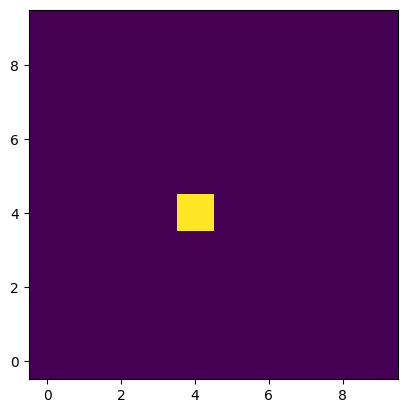

In [164]:
# hyperparameters

env = GridWorldEnv(size=SIZE)

# env.heatmap_env()
# env.random_env()
env.setReward(4, 4, 9)

plt.imshow(env.world, cmap='viridis')
plt.gca().invert_yaxis()
plt.show()

env_timelimit = gym.wrappers.TimeLimit(env, max_episode_steps=1000000)

agent = SAR_agent(
    0,
    env=env,
    alpha=ALPHA,
    beta=BETA,
    epsilon=EPSILON,
    gamma=GAMMA
)


# agent1 = SAR_agent(
#     1,
#     env=env,
#     alpha=ALPHA,
#     beta=BETA,
#     gamma=GAMMA
# )

# agent2 = SAR_agent(
#     2,
#     env=env,
#     alpha=ALPHA,
#     beta=BETA,
#     gamma=GAMMA
# )

# agent3 = SAR_agent(
#     3,
#     env=env,
#     alpha=ALPHA,
#     beta=BETA,
#     gamma=GAMMA
# )

# agent4 = SAR_agent(
#     4,
#     env=env,
#     alpha=ALPHA,
#     beta=BETA,
#     gamma=GAMMA
# )

agents = []
agents.append(agent)
# agents.append(agent1)
# agents.append(agent2)
# agents.append(agent3)
# agents.append(agent4)

In [165]:
swarm1 = swarm(env, agents, N_EPISODES, UPDATE_STEP)

swarm1.train_swarm(STEPS)

Training Progress:   0%|          | 0/10000 [00:00<?, ?episode/s]

#### Evaluation

'Q-table'

0.0                                           \
  (0.0, 0.0, 0.0, 0.0) (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)   
                   0.0                                      1.0   
0                  0.0                                      0.0   
1                  0.0                                      0.0   
2                  0.0                                      0.0   
3                  0.0                                      0.0   

                                                            1.0  \
  (0.0, 0.0, 0.0, 0.0) (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)   
                   1.0                                      1.0   
0                  0.0                                 0.000000   
1                  0.0                                -4.500957   
2                  0.0                                -2.381662   
3                  0.0                                -7.509211   

                                       2.0  \
  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)   
                                       1.0   
0                                 2.269099   
1                                 1.485834   
2                                -4.753382   
3                                -2.207312   

                                       3.0  \
  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)   
                                       1.0   
0                                 1.752054   
1                                -1.765920   
2                                -3.942289   
3                                -2.685288   

                                       4.0  \
  (0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)   
                                       1.0   
0                                -8.045237   
1                                -8.956064   
2                                 1.518063   
3                                -2.369563   

                                            \
  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)   
                                       1.0   
0                                 1.602862   
1                                -3.158317   
2                                -2.408036   
3                                -1.724893   

                                       5.0  \
  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)   
                                       1.0   
0                                -2.540565   
1                                -9.921303   
2                               -10.536806   
3                                -4.198192   

                                       3.0  ...  \
  (0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)  ...   
                                       1.0  ...   
0                                -6.987012  ...   
1                                 1.897151  ...   
2                                -1.846782  ...   
3                                -2.564732  ...   

                                       7.0  \
  (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0)   
                                       1.0   
0                               -36.527193   
1                               -36.944972   
2                               -30.684700   
3                               -23.850800   

                                       9.0  \
  (0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)   
                                       1.0   
0                               -57.743712   
1                               -56.618246   
2                               -43.580315   
3                               -58.155335   

                                       1.0  \
  (0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)   
                                       1.0   
0                                    -10.0   
1                                      0.0   
2                                    -10.0   
3                                      0.0   

                                       6.0  \
  (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0)   
                                       1.0   

Training Progress:   0%|          | 0/10 [00:00<?, ?episode/s]

array([0., 0., 0., 0.])

Taking action:  0


array([0., 0., 0., 0.])

Taking action:  0


array([ 0.        , -4.5009568 , -2.38166187, -7.50921112])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-6.98701189,  1.89715054, -1.84678219, -2.56473191])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-7.23768312, -7.84439416,  2.88651498,  0.86524066])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-5.53660489, -3.89583461, -5.38589796,  5.02616134])

Taking action:  3


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 1.75205434, -1.76591999, -3.94228941, -2.68528812])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.60286162, -3.15831708, -2.40803573, -1.72489251])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.75205434, -1.76591999, -3.94228941, -2.68528812])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-8.14390473,  1.55118339, -1.26668582, -3.94611495])

Taking action:  1


array([-6.98701189,  1.89715054, -1.84678219, -2.56473191])

Taking action:  1


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.60286162, -3.15831708, -2.40803573, -1.72489251])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.60286162, -3.15831708, -2.40803573, -1.72489251])

Taking action:  0


array([-37.51690778, -42.10236907, -41.04916695, -39.51121972])

Taking action:  0


array([-31.12326383, -39.93197865, -36.46974206, -35.58607252])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-55.74259747, -52.23279483, -49.45680693, -51.46948089])

Taking action:  2


array([-52.40975487, -54.45798224, -53.605895  , -36.82452235])

Taking action:  3


array([0., 0., 0., 0.])

Taking action:  0


array([-38.36000495, -42.0521717 , -37.90973693, -32.62614516])

Taking action:  3


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([0., 0., 0., 0.])

Taking action:  0


array([0., 0., 0., 0.])

Taking action:  0


array([ 0.        , -4.5009568 , -2.38166187, -7.50921112])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-6.98701189,  1.89715054, -1.84678219, -2.56473191])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-7.23768312, -7.84439416,  2.88651498,  0.86524066])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-5.53660489, -3.89583461, -5.38589796,  5.02616134])

Taking action:  3


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 1.75205434, -1.76591999, -3.94228941, -2.68528812])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.60286162, -3.15831708, -2.40803573, -1.72489251])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.75205434, -1.76591999, -3.94228941, -2.68528812])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-8.14390473,  1.55118339, -1.26668582, -3.94611495])

Taking action:  1


array([-6.98701189,  1.89715054, -1.84678219, -2.56473191])

Taking action:  1


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.60286162, -3.15831708, -2.40803573, -1.72489251])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.60286162, -3.15831708, -2.40803573, -1.72489251])

Taking action:  0


array([-37.51690778, -42.10236907, -41.04916695, -39.51121972])

Taking action:  0


array([-31.12326383, -39.93197865, -36.46974206, -35.58607252])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-55.74259747, -52.23279483, -49.45680693, -51.46948089])

Taking action:  2


array([-52.40975487, -54.45798224, -53.605895  , -36.82452235])

Taking action:  3


array([0., 0., 0., 0.])

Taking action:  0


array([-38.36000495, -42.0521717 , -37.90973693, -32.62614516])

Taking action:  3


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([0., 0., 0., 0.])

Taking action:  0


array([0., 0., 0., 0.])

Taking action:  0


array([ 0.        , -4.5009568 , -2.38166187, -7.50921112])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-6.98701189,  1.89715054, -1.84678219, -2.56473191])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-7.23768312, -7.84439416,  2.88651498,  0.86524066])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-5.53660489, -3.89583461, -5.38589796,  5.02616134])

Taking action:  3


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 1.75205434, -1.76591999, -3.94228941, -2.68528812])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.60286162, -3.15831708, -2.40803573, -1.72489251])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.75205434, -1.76591999, -3.94228941, -2.68528812])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-8.14390473,  1.55118339, -1.26668582, -3.94611495])

Taking action:  1


array([-6.98701189,  1.89715054, -1.84678219, -2.56473191])

Taking action:  1


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.60286162, -3.15831708, -2.40803573, -1.72489251])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.60286162, -3.15831708, -2.40803573, -1.72489251])

Taking action:  0


array([-37.51690778, -42.10236907, -41.04916695, -39.51121972])

Taking action:  0


array([-31.12326383, -39.93197865, -36.46974206, -35.58607252])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-55.74259747, -52.23279483, -49.45680693, -51.46948089])

Taking action:  2


array([-52.40975487, -54.45798224, -53.605895  , -36.82452235])

Taking action:  3


array([0., 0., 0., 0.])

Taking action:  0


array([-38.36000495, -42.0521717 , -37.90973693, -32.62614516])

Taking action:  3


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([0., 0., 0., 0.])

Taking action:  0


array([0., 0., 0., 0.])

Taking action:  0


array([ 0.        , -4.5009568 , -2.38166187, -7.50921112])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-6.98701189,  1.89715054, -1.84678219, -2.56473191])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-7.23768312, -7.84439416,  2.88651498,  0.86524066])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-5.53660489, -3.89583461, -5.38589796,  5.02616134])

Taking action:  3


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 1.75205434, -1.76591999, -3.94228941, -2.68528812])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.60286162, -3.15831708, -2.40803573, -1.72489251])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.75205434, -1.76591999, -3.94228941, -2.68528812])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-8.14390473,  1.55118339, -1.26668582, -3.94611495])

Taking action:  1


array([-6.98701189,  1.89715054, -1.84678219, -2.56473191])

Taking action:  1


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.60286162, -3.15831708, -2.40803573, -1.72489251])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.60286162, -3.15831708, -2.40803573, -1.72489251])

Taking action:  0


array([-37.51690778, -42.10236907, -41.04916695, -39.51121972])

Taking action:  0


array([-31.12326383, -39.93197865, -36.46974206, -35.58607252])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-55.74259747, -52.23279483, -49.45680693, -51.46948089])

Taking action:  2


array([-52.40975487, -54.45798224, -53.605895  , -36.82452235])

Taking action:  3


array([0., 0., 0., 0.])

Taking action:  0


array([-38.36000495, -42.0521717 , -37.90973693, -32.62614516])

Taking action:  3


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([0., 0., 0., 0.])

Taking action:  0


array([0., 0., 0., 0.])

Taking action:  0


array([ 0.        , -4.5009568 , -2.38166187, -7.50921112])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-6.98701189,  1.89715054, -1.84678219, -2.56473191])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-7.23768312, -7.84439416,  2.88651498,  0.86524066])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-5.53660489, -3.89583461, -5.38589796,  5.02616134])

Taking action:  3


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 1.75205434, -1.76591999, -3.94228941, -2.68528812])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.60286162, -3.15831708, -2.40803573, -1.72489251])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.75205434, -1.76591999, -3.94228941, -2.68528812])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-8.14390473,  1.55118339, -1.26668582, -3.94611495])

Taking action:  1


array([-6.98701189,  1.89715054, -1.84678219, -2.56473191])

Taking action:  1


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.60286162, -3.15831708, -2.40803573, -1.72489251])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.60286162, -3.15831708, -2.40803573, -1.72489251])

Taking action:  0


array([-37.51690778, -42.10236907, -41.04916695, -39.51121972])

Taking action:  0


array([-31.12326383, -39.93197865, -36.46974206, -35.58607252])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-55.74259747, -52.23279483, -49.45680693, -51.46948089])

Taking action:  2


array([-52.40975487, -54.45798224, -53.605895  , -36.82452235])

Taking action:  3


array([0., 0., 0., 0.])

Taking action:  0


array([-38.36000495, -42.0521717 , -37.90973693, -32.62614516])

Taking action:  3


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([0., 0., 0., 0.])

Taking action:  0


array([0., 0., 0., 0.])

Taking action:  0


array([ 0.        , -4.5009568 , -2.38166187, -7.50921112])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-6.98701189,  1.89715054, -1.84678219, -2.56473191])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-7.23768312, -7.84439416,  2.88651498,  0.86524066])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-5.53660489, -3.89583461, -5.38589796,  5.02616134])

Taking action:  3


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 1.75205434, -1.76591999, -3.94228941, -2.68528812])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.60286162, -3.15831708, -2.40803573, -1.72489251])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.75205434, -1.76591999, -3.94228941, -2.68528812])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-8.14390473,  1.55118339, -1.26668582, -3.94611495])

Taking action:  1


array([-6.98701189,  1.89715054, -1.84678219, -2.56473191])

Taking action:  1


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.60286162, -3.15831708, -2.40803573, -1.72489251])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.60286162, -3.15831708, -2.40803573, -1.72489251])

Taking action:  0


array([-37.51690778, -42.10236907, -41.04916695, -39.51121972])

Taking action:  0


array([-31.12326383, -39.93197865, -36.46974206, -35.58607252])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-55.74259747, -52.23279483, -49.45680693, -51.46948089])

Taking action:  2


array([-52.40975487, -54.45798224, -53.605895  , -36.82452235])

Taking action:  3


array([0., 0., 0., 0.])

Taking action:  0


array([-38.36000495, -42.0521717 , -37.90973693, -32.62614516])

Taking action:  3


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([0., 0., 0., 0.])

Taking action:  0


array([0., 0., 0., 0.])

Taking action:  0


array([ 0.        , -4.5009568 , -2.38166187, -7.50921112])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-6.98701189,  1.89715054, -1.84678219, -2.56473191])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-7.23768312, -7.84439416,  2.88651498,  0.86524066])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-5.53660489, -3.89583461, -5.38589796,  5.02616134])

Taking action:  3


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 1.75205434, -1.76591999, -3.94228941, -2.68528812])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.60286162, -3.15831708, -2.40803573, -1.72489251])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.75205434, -1.76591999, -3.94228941, -2.68528812])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-8.14390473,  1.55118339, -1.26668582, -3.94611495])

Taking action:  1


array([-6.98701189,  1.89715054, -1.84678219, -2.56473191])

Taking action:  1


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.60286162, -3.15831708, -2.40803573, -1.72489251])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.60286162, -3.15831708, -2.40803573, -1.72489251])

Taking action:  0


array([-37.51690778, -42.10236907, -41.04916695, -39.51121972])

Taking action:  0


array([-31.12326383, -39.93197865, -36.46974206, -35.58607252])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-55.74259747, -52.23279483, -49.45680693, -51.46948089])

Taking action:  2


array([-52.40975487, -54.45798224, -53.605895  , -36.82452235])

Taking action:  3


array([0., 0., 0., 0.])

Taking action:  0


array([-38.36000495, -42.0521717 , -37.90973693, -32.62614516])

Taking action:  3


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([0., 0., 0., 0.])

Taking action:  0


array([0., 0., 0., 0.])

Taking action:  0


array([ 0.        , -4.5009568 , -2.38166187, -7.50921112])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-6.98701189,  1.89715054, -1.84678219, -2.56473191])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-7.23768312, -7.84439416,  2.88651498,  0.86524066])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-5.53660489, -3.89583461, -5.38589796,  5.02616134])

Taking action:  3


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 1.75205434, -1.76591999, -3.94228941, -2.68528812])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.60286162, -3.15831708, -2.40803573, -1.72489251])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.75205434, -1.76591999, -3.94228941, -2.68528812])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-8.14390473,  1.55118339, -1.26668582, -3.94611495])

Taking action:  1


array([-6.98701189,  1.89715054, -1.84678219, -2.56473191])

Taking action:  1


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.60286162, -3.15831708, -2.40803573, -1.72489251])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.60286162, -3.15831708, -2.40803573, -1.72489251])

Taking action:  0


array([-37.51690778, -42.10236907, -41.04916695, -39.51121972])

Taking action:  0


array([-31.12326383, -39.93197865, -36.46974206, -35.58607252])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-55.74259747, -52.23279483, -49.45680693, -51.46948089])

Taking action:  2


array([-52.40975487, -54.45798224, -53.605895  , -36.82452235])

Taking action:  3


array([0., 0., 0., 0.])

Taking action:  0


array([-38.36000495, -42.0521717 , -37.90973693, -32.62614516])

Taking action:  3


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([0., 0., 0., 0.])

Taking action:  0


array([0., 0., 0., 0.])

Taking action:  0


array([ 0.        , -4.5009568 , -2.38166187, -7.50921112])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-6.98701189,  1.89715054, -1.84678219, -2.56473191])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-7.23768312, -7.84439416,  2.88651498,  0.86524066])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-5.53660489, -3.89583461, -5.38589796,  5.02616134])

Taking action:  3


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 1.75205434, -1.76591999, -3.94228941, -2.68528812])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.60286162, -3.15831708, -2.40803573, -1.72489251])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.75205434, -1.76591999, -3.94228941, -2.68528812])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-8.14390473,  1.55118339, -1.26668582, -3.94611495])

Taking action:  1


array([-6.98701189,  1.89715054, -1.84678219, -2.56473191])

Taking action:  1


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.60286162, -3.15831708, -2.40803573, -1.72489251])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.60286162, -3.15831708, -2.40803573, -1.72489251])

Taking action:  0


array([-37.51690778, -42.10236907, -41.04916695, -39.51121972])

Taking action:  0


array([-31.12326383, -39.93197865, -36.46974206, -35.58607252])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-55.74259747, -52.23279483, -49.45680693, -51.46948089])

Taking action:  2


array([-52.40975487, -54.45798224, -53.605895  , -36.82452235])

Taking action:  3


array([0., 0., 0., 0.])

Taking action:  0


array([-38.36000495, -42.0521717 , -37.90973693, -32.62614516])

Taking action:  3


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([0., 0., 0., 0.])

Taking action:  0


array([0., 0., 0., 0.])

Taking action:  0


array([ 0.        , -4.5009568 , -2.38166187, -7.50921112])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-6.98701189,  1.89715054, -1.84678219, -2.56473191])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-7.72616792,  2.20129975, -1.6334907 , -3.62813257])

Taking action:  1


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-7.23768312, -7.84439416,  2.88651498,  0.86524066])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-6.45259195, -8.12935135,  2.50997791, -0.22524256])

Taking action:  2


array([-5.53660489, -3.89583461, -5.38589796,  5.02616134])

Taking action:  3


array([ 2.26909922,  1.48583373, -4.7533823 , -2.20731227])

Taking action:  0


array([ 1.75205434, -1.76591999, -3.94228941, -2.68528812])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.60286162, -3.15831708, -2.40803573, -1.72489251])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.75205434, -1.76591999, -3.94228941, -2.68528812])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-8.14390473,  1.55118339, -1.26668582, -3.94611495])

Taking action:  1


array([-6.98701189,  1.89715054, -1.84678219, -2.56473191])

Taking action:  1


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.60286162, -3.15831708, -2.40803573, -1.72489251])

Taking action:  0


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([-42.53299606, -42.33737032, -23.0617362 , -30.93118565])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-10.54801925, -12.09383424, -10.96403011,  -1.40558322])

Taking action:  3


array([ -2.54056479,  -9.92130341, -10.53680598,  -4.1981918 ])

Taking action:  0


array([ 1.60286162, -3.15831708, -2.40803573, -1.72489251])

Taking action:  0


array([-37.51690778, -42.10236907, -41.04916695, -39.51121972])

Taking action:  0


array([-31.12326383, -39.93197865, -36.46974206, -35.58607252])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-49.28398059, -53.78584028, -52.1490788 , -51.54368885])

Taking action:  0


array([-55.74259747, -52.23279483, -49.45680693, -51.46948089])

Taking action:  2


array([-52.40975487, -54.45798224, -53.605895  , -36.82452235])

Taking action:  3


array([0., 0., 0., 0.])

Taking action:  0


array([-38.36000495, -42.0521717 , -37.90973693, -32.62614516])

Taking action:  3


array([-41.94835894, -42.0019044 , -32.60740784, -38.00401392])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


array([-11.69607781, -12.11978618,  -1.56002791,  -6.99473148])

Taking action:  2


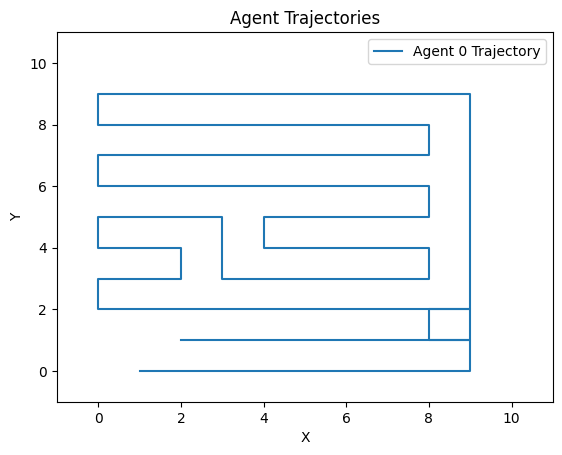

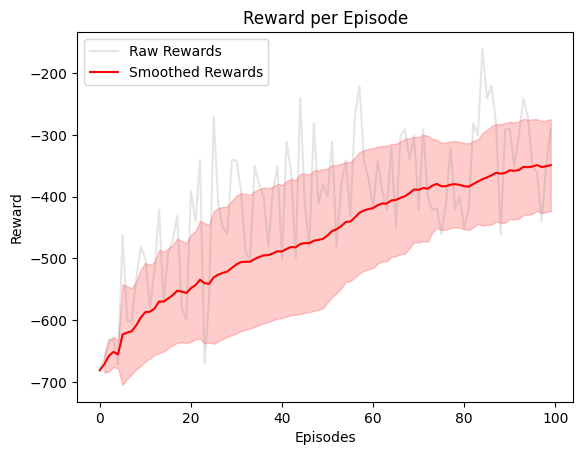

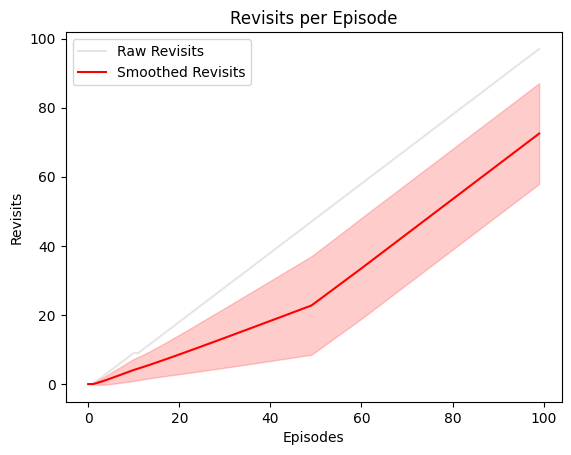

In [166]:
display("Q-table", pd.DataFrame(agent.q_values))
swarm1.evaluate_swarm(EVALUATION_STEPS,10)
swarm1.plot_trajectories()
swarm1.plot_reward_episode(EVALUATION_STEPS)
swarm1.plot_revisited(EVALUATION_STEPS)
# swarm1.plot_info(EVALUATION_STEPS)

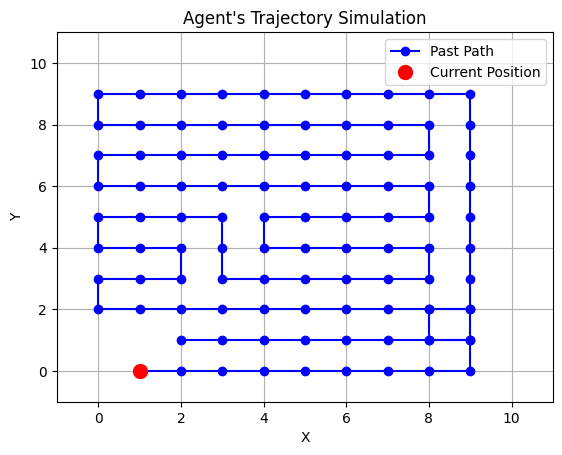

In [167]:
agents[0].plot_trajectory(0.05)